https://colab.research.google.com/drive/1TYGkW7UI_yEiHnKM7EpqWOPreNlGzohA

# CODE 7: Increase the Capacity

_"The Capacity to learn is a **Gift**, the Ability to learn is a **Skill**, the Willingness to learn is a **Choice**"_    --Successful Student

Target:

1. Increase model capacity. Add more layers at the end.
2. Result:
    1. Parameters: 11.9k
    2. Best Train Accuracy: 99.33
    3. Best Test Accuracy: 99.04
3. Analysis:
    1. The model still showing over-fitting, possibly DropOut is not working as expected! Wait yes! We don't know which layer is causing over-fitting. Adding it to a specific layer wasn't a great idea.
    2. Quite Possibly we need to add more capacity, especially at the end.
    3. Closer analysis of MNIST can also reveal that just at RF of 5x5 we start to see patterns forming.
    4. We can also increase the capacity of the model by **adding a layer after GAP!**

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 103171424.78it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 90942713.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25901147.88it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18265128.25it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


AttributeError: ignored

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 5
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 5
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.15517620742321014 Batch_id=468 Accuracy=82.38: 100%|██████████| 469/469 [00:19<00:00, 23.98it/s]



Test set: Average loss: 0.4737, Accuracy: 8500/10000 (85.00%)

EPOCH: 1


Loss=0.05157714709639549 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]



Test set: Average loss: 0.1424, Accuracy: 9604/10000 (96.04%)

EPOCH: 2


Loss=0.038243018090724945 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:18<00:00, 26.06it/s]



Test set: Average loss: 0.1993, Accuracy: 9387/10000 (93.87%)

EPOCH: 3


Loss=0.09625473618507385 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:17<00:00, 26.55it/s]



Test set: Average loss: 0.1380, Accuracy: 9575/10000 (95.75%)

EPOCH: 4


Loss=0.008819338865578175 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:19<00:00, 23.82it/s]



Test set: Average loss: 0.0567, Accuracy: 9836/10000 (98.36%)

EPOCH: 5


Loss=0.03814196586608887 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]



Test set: Average loss: 0.0854, Accuracy: 9726/10000 (97.26%)

EPOCH: 6


Loss=0.019087085500359535 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]



Test set: Average loss: 0.0494, Accuracy: 9842/10000 (98.42%)

EPOCH: 7


Loss=0.05842439457774162 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]



Test set: Average loss: 0.0838, Accuracy: 9739/10000 (97.39%)

EPOCH: 8


Loss=0.031596582382917404 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 26.29it/s]



Test set: Average loss: 0.0505, Accuracy: 9850/10000 (98.50%)

EPOCH: 9


Loss=0.012726793996989727 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]



Test set: Average loss: 0.0680, Accuracy: 9783/10000 (97.83%)

EPOCH: 10


Loss=0.022121017798781395 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 26.74it/s]



Test set: Average loss: 0.0779, Accuracy: 9751/10000 (97.51%)

EPOCH: 11


Loss=0.008670867420732975 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 25.06it/s]



Test set: Average loss: 0.0607, Accuracy: 9814/10000 (98.14%)

EPOCH: 12


Loss=0.07616553455591202 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]



Test set: Average loss: 0.0430, Accuracy: 9868/10000 (98.68%)

EPOCH: 13


Loss=0.007742537651211023 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]



Test set: Average loss: 0.0726, Accuracy: 9777/10000 (97.77%)

EPOCH: 14


Loss=0.004553579725325108 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]



Test set: Average loss: 0.0434, Accuracy: 9870/10000 (98.70%)

EPOCH: 15


Loss=0.011823096312582493 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]



Test set: Average loss: 0.0466, Accuracy: 9850/10000 (98.50%)

EPOCH: 16


Loss=0.030195215716958046 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s]



Test set: Average loss: 0.0339, Accuracy: 9894/10000 (98.94%)

EPOCH: 17


Loss=0.04987773671746254 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:18<00:00, 24.94it/s]



Test set: Average loss: 0.0478, Accuracy: 9849/10000 (98.49%)

EPOCH: 18


Loss=0.005478643346577883 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]



Test set: Average loss: 0.0366, Accuracy: 9881/10000 (98.81%)

EPOCH: 19


Loss=0.003676382126286626 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]



Test set: Average loss: 0.0408, Accuracy: 9883/10000 (98.83%)



Text(0.5, 1.0, 'Test Accuracy')

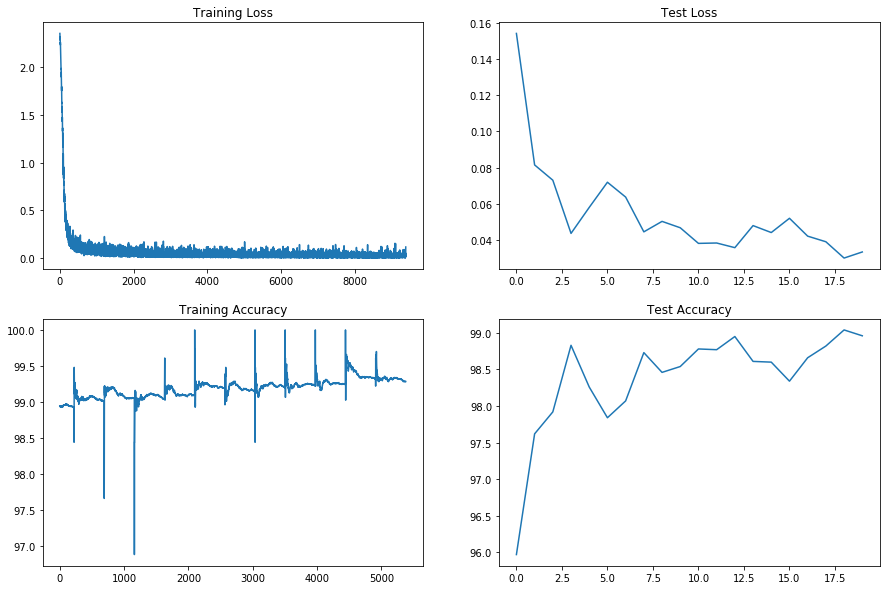

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")